---
>「翻訳は作品のあらを大きくし、その美しさをスポイルする。」 \
>（ヴォルテール ｢叙情詩｣）
---

# Attention

Attentionはその後"Attention is all you need"という論文でも取り上げられ、事前言語分野で大きな成果を生み出したTransformerにも利用される重要な仕組み

Attentionは注目と翻訳される通り、アテンション機構はデータのどの部分に注目すればよいかを判断する機構として説明される
- データの重要な部分についてより大きい重み付けを行う

但し、この説明では、FCなども重要な入力要素に対して重みを大きく与えることでは同じであり、本質的な差を表現していない

- 通常のニューラルネットにおける学習パラメータ(重み)は入力ベクトル内の各要素についての重み付けである
- アテンションは、複数のベクトルを束ねた系列データについて、各ベクトル間の関係についての重みづけである

## Attentionはなぜ生み出されたか

エンコーダ-デコーダモデルにおける効率化のためにAttentionが提案された

RNNによるエンコーダ-デコーダモデルにおいて、次のような問題があった
- 1つ目の単語から順次処理する過程において、処理される度に単語の情報が薄まる(長期記憶忘却問題、勾配消失ではない)
- エンコーダからデコーダに渡される文脈ベクトルが固定次元であるため表現力が乏しい(固定次元問題)
- 逐次処理となるため計算に時間がかかる(並列化問題)

Attentionを導入することにより、次のように解決することができる
- エンコーダとデコーダをアテンション機構でつなげることで、大域的な文脈を失わずに処理することができる(長期記憶忘却問題と固定次元問題を解決)
- セルフアテンションにより系列内の単語間関係を捉えることができるトランスフォーマーにより、RNNブロック自体を排除し、計算の並列化が可能となった(並列化問題を解決)




## Query, Key, Value

Attentionは一般に、データを検索する鍵(Key)と実際の値(Value)のペア集合に対して、問い合わせ(Query)を投げて値を取り出す操作であると説明されている

QueryとKeyの類似度に基づく重みが計算され、その加重平均としてValueが求められる

深層学習では、基本的にあらゆる特徴量はベクトルを並べたテンソルとして表現される

例えば、次のベクトルを考える
- $d_k$次元のベクトルであるQuery、および$d_v$次元のベクトルであるValue
- Queryが$N$個並んだ行列である$Q \in \mathbb{R}^{N \times d_k}$
- 同様にkeyとして$M$個並んだ$K \in \mathbb{R}^{M \times d_k}$、およびValueとして$V \in \mathbb{R}^{M \times d_v}$

基本的なAttention (Scaled Dot-Product Attention) は次の行列演算で与えることができる

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V=AV\in \mathbb{R}^{M \times d_v}$$

なお、実際にはこの式には複数の要素を持つ$Q$や$K$、$V$が用いられ、バッチなどデータの塊を入力することになる

- softmaxにより、各Queryに対して、全てのKeyへの重みの総和が1となる

- したがって、$K$と$Q$の内積つまり類似度を表すため、$K$と$Q$との一致度合いをみて、一致している各要素の度合に合わせて$V$にある相当する値の和を出力するといった動作となる

- 得られた値$A = softmax(\frac{QK^T}{\sqrt{d_k}})$は各QueryとKeyのペアの類似度を示すヒートマップのような役割を果たし、Attention Matrixなどと呼称される

- 高次元のベクトルであるほど、見かけ上の長さが長くなり、長さが評価に影響すると正しい評価が困難になる
  - これを補正するため、妥協的に$\sqrt{d_k}$で割ることで、次元$d_k$が高いほど、距離を短く補正している

Attention機構は、系列内のとある要素としてのベクトルから見て、ほかの要素のどれが強い関連性を持つかを獲得しているが、同時に内積を演算していることから、系列全体の情報を取り込んで混ぜ合わせるという処理も行っており、両方が重要である
- 重要度に重みをつけながら、系列全体の要素間関係を捉える処理であり、部分的な関係の抽出と、全体をとらえるという両方の役割を同時に満たしていると説明できる

## Attentionの種類

Q,K,Vをどのように与えるかで次の種類がある
- なお、基本的にKeyとValueはセットで与えられる


### Self-Attention

ある一つの入力$X$について、別の変換行列を適用、$Q=XW_Q, K=XW_K, V=XW_V$を求めて利用する
- 自分自身の要素との注目度合いを抽出する

自分自身の中での関係性を抽出するためSelf-Attentionと呼ぶ


### Masked Self-Attention

例えば既にある文章から次の単語を予測するなど、順に要素を予測していくタスク、すなわち自己回帰生成タスクなどで用いる場合、Self-Attentionの各要素が自身より未来の要素を参照すると未来を使って未来を予測するというチートになるため、これを防ぐためのMaskを与える

このようなマスクを利用したSelf-Attentionをmaxked Self-Attentionと呼ぶ

- このマスクは、三角行列の形をしている
- Self-Attentionの一種

TransformerのCross-Attention層では、K、V、Qすべてが同じ値であり、各単語の意味ベクトルを変換した行列である
- 全く同じ行列を3つの入口に投入し、それぞれ別の線形変換をした上でAttention処理を行っている


### Cross-Attention

異なる入力$X$と$Y$について、$Q=XW_Q, K=YW_K, V=YW_V$を求めて利用する
- $X$が異なる情報源$Y$から情報を抽出する処理と解釈できる
- source-target attentionとも呼ばれる

TransformerのCross-Attention層では、KとVはどちらもEncoderの出力行列であり、各単語の意味ベクトルを変換した行列で、同じ値が入力される
- ただし、Attention層の入力にあるFC層によりKとVには別々の変換が施されるため、結果的に別物になる
- Qはデコーダ側の入力単語ベクトルを重ねた行列


### Multi-head Attention

埋め込みベクトルが分割され、処理されるAttentionである

数式では次のように表すことができる

$$MHA(Q, K, V) = concat(head_i)W^O$$

ここで

$$head_i=Attention(QW^Q_i, KW^K_i, VW^V_i)$$

である

Q, K, Wに対して、$W^Q_i$, $W^K_i$, $W^V_i$という重み行列を掛けて、Attentionを求め、さらに$W^O$という重み行列を掛けて、行列を1次元ベクトルに変換するといった動作となる

例えば、Transformerでは、$W^Q_i$, $W^K_i$, $W^V_i$は一般に8次元であり、入力列を8個の列に重みを掛けて拡張し、それに対してAttentionを求め、さらに一列にするという動作である

各特徴量をより小さい次元のベクトルへ分割し、それぞれの分割グループでAttentionを適用して最後に結合する手法
- QueryからKeyへ注目するパターンを並列で複数学習できることから表現力の向上が期待できる

Transformerで実際に利用されるAttentionは Multi-head Attentionであり、系列を構成するベクトル間の関係を複数の観点で捉えることができる

ただ、これについても本質的にはかなり特殊なことが行なわれている
- 「MLの勉強は楽しい」という文章では、「勉強」と「楽しい」という関係が読み取れるが、「ML」と「勉強」にも当然関係を読み取ることができる
- このような複数の関係を同時に読み取ることを考えるが、単純にヘッドを複数用意して同じ単語トークンのベクトルを与えればよいわけではない
- 実際には、単語トークンのベクトルを分割してそれぞれに異なる場所を与えているため、ある意味異なる単語として扱っていると判断した方が適切である
- しかしながら、同じ単語であれば同じトークンベクトルの分割部分ベクトルが与えられるため、結果的にその分割処理すらも学習され、潜在空間上ではまとまった場所で表現されるようになるといえる

Transformer における Attentionについては、Transformerで改めて説明する

# Self-Attentionの画像処理における意味

基本的には、これまでと同じ議論でよい

今まで何がまずかったのか？
- Convolutionつまり畳み込み層は、カーネルを適用できる範囲の特徴を抽出し、この局所的情報を一般的にはさらに広い局所的な範囲で拡大するという連続で利用する
- カーネルそのものが限定された範囲のみ対象としており、カーネルを大きくすると計算コストが増える
- 拡大する際に画像全体の大域的な情報は考慮されない

ではどのようにするのか？
- ある層の出力$x$をそのまま使うと上記の問題が発生するため、その出力に大域的な情報を考慮した調整項を加えようという作戦
- 調整項は、大域的な情報$\omicron$と、係数$\gamma$を掛けた値とし、次の層への入力$y$を$y=x+\gamma \omicron$として与える作戦
- $\omicron$を獲得するのに全結合層を利用するのはコストが大きすぎ、また、画像であればチャネル数$C$ $\times$ 高さ $H$ $\times$ 幅 $W$である$x$の線形和しか獲得できず、表現力が乏しいので、なんとか積の形を取り入れる

なお、実際にはSAGANが先に提案され、その中で用いられたAttentionの能力について、"Attention is all you need"という論文で説明された結果、それを用いたTransfomerが提案された、という経緯がある




実際には、次のような処理を施す
- 入力$x:C\times H\times W$を変形して$t$を作る
  - これはviewメソッドで簡単にできる
- $t:C\times N$について$S=t^Tt$を求める
  - permuteメソッドで簡単にできる
- Sの要素$s_{i,j}$は画素$i$が画素$j$とどの程度似ているるか、実際には、どの程度、同様に大きいのかを示している(面倒なのでこれを似非類似と呼ぶ)
  - ある画素のあるチャネルと、別の画素の同じチャネルの値を掛け、それらの和を求めるということを、全ての画素について行っていることになる
  - torch.bmm関数でできる(このノートブックの末尾参照)
- Sを正規化するため行方向にSoftmax関数を施す
  - これで行方向の総和は1になる
  - nn.Softmax()を用いればよいが、dim=-2となる
- 転置して$\beta$を得るが、$\beta_{j,i}$は、位置$j$と位置$i$がどの程度似非類似しているか、つまり、位置$j$を生成する際にどの程度位置$i$を考慮するべきかを示す
- この$\beta$をAttention Mapと呼び、$x$を大域的な情報を用いて調整する Self-Attention Mapの$\omicron$は、$\omicron = x\beta^T$として求めることができる
  - この掛け算でもbmm関数を利用する

以上がSelf-Attentionの仕組みであり
- 入力$x$のある要素に対して特徴量を求めたいとするならば、着目するべきはそれ自身と似非類似している要素であり、これに限定する
- この限定により計算コストを抑える

<img src="http://class.west.sd.keio.ac.jp/dataai/text/genself-attention.png" width=700>

# SAGAN

GANの提唱者であるLan Goodfellowらが2018年に提唱したGAN
- SAGANをベースに構築しているモデルは多々ある
- いくつかの重要な拡張が加えられている
- 特にSelf-Attentionは重要

## SAGANの特徴
- Self-Attention
- Pointwise convolution
  - 1x1 convolutions

- Spectral Normalization


### Pointwise Convolution

Self-Attentionは強力であるが弱点もあり、「入力$x$のある要素に対して特徴量を求めたいとするならば、着目するべきはそれ自身と似非類似している要素であり、これに限定する」という制約がかなり厳しい制約である、という問題がある

似ていなくても影響を与えることは普通に考えられるであろう

そこで、$x$をそのままSelf-Attentionの計算に用いず、一度特徴量変換してからSelf-Attentionに与えるようにする
- 特徴量変換には様々考えられるが、カーネルサイズが$1\times 1$の畳み込み層を用いて特徴量を抽出するという考え方
- チャネル数は自由に変更できるが、通常は元のチャネル数$C$よりも小さな値とするため、次元圧縮ととらえることができる
- 誤差逆伝搬の際に、この圧縮で情報が欠落し難い線形和の計数(pointwise convolutionのカーネル重み)を学習してくれるはずで、これを利用する

Pointwise ConvolutionをSelf-Attentionの前処理とする理由は次の通り
- すでに述べた通り、似非類似を特徴量とする厳しい制約を緩和したい
- Cを小さくして計算コストを削減したい
  - この用途のため、MobileNetsと呼ばれるエッジ向け低コストモデルでも利用される

### Spectral Normalization

GANが上手く機能するためには、「Discriminatorへの入力が状が少し変化した程度では、Discriminatorの出力は殆ど変化しない」というリプシッツ連続性を備えている必要がある

このリプシッツ連続性を獲得するための操作が Spectral Normalization

正規化操作の一種
- Batch NormalizationはDNNモデル内を流れるデータの塊、バッチに対する正規化
- Spectral Normalizationは畳み込み層などのネットワークの重みパラメータを正規化
- 正規化することで、最大値を1として正規化されるため、最大固有値も制限を受け、拡大変換行列としての機能を失わせるという効果を獲得することができる
- SAGANでは、Discriminatorだけでなく、GeneratorにもSpectral Normalizationを利用する

PyTorchでは次のようにして利用する
```
nn.utils.spectral_norm(nn.ConvTranspose2d(...)
```


## SAGANの実装

MNISTの一部数字を用い、その数字を再生成するモデルを構築する

### GANでクロスエントロピーロスを利用する時の問題点

LOSSの計算に、
```
criterion = nn.BCEWithLogitsLoss(reduction='mean')
```
とし、
```
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
```
や
```
g_loss = criterion(d_out_fake.view(-1), label_real)
```
としても計算可能であるが、安定しにくい

Dが強くなりすぎる原因は何か

- Discriminatorに利用する損失関数として交差エントロピーが考えられるが、交差エントロピーのロジットの微分がシグモイド関数に等しいということから理解できる

まずこれを示そう

ある画像$p$の真偽のを予測確率を$\tilde{p}$とすると、交差エントロピーは
$$−p\log(\tilde{p})−(1−p)\log(1−\tilde{p})$$
これを微分して、勾配を調べる$p=0,1p=0,1$とすると、$\tilde{p}$のみを用いて
$$E_{p=0}=−\log(1−\tilde{p})$$
$$E_{p=1}=−\log \tilde{p}$$
と表せる

シグモイド関数$\sigma(x)$とすると、
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
である

交差エントロピーのロジットは、
$$\tilde{p} = \sigma(x)$$
とすればよく、その微分は、
$$\frac{d}{dx}\sigma(x)=\frac{d\tilde{p}}{dx}=\frac{e^{-x}}{(1-e^{-x})^2}=(1-\sigma(x))\sigma(x)$$
となる

ここで、
$$\frac{d}{dx}E_{p=0}=\frac{dE_{p=0}}{d\tilde{p}}\frac{d\tilde{p}}{dx}=\frac{1}{1-\tilde{p}}\frac{d\tilde{p}}{dx}= \frac{1}{1-\sigma(x)}(1-\sigma(x))\sigma(x)=\sigma(x)$$
となり、同様に、
$$\frac{d}{dx}E_{p=1}=\sigma(x)-1$$
となる

このようにシグモイド関数で表すことができ、和は当然ながら$1$となる

微分がシグモイド関数になるということは、
- $p=0$では$x\rightarrow -\infty$に、$p=1$の場合は$x\rightarrow \infty$としてもEの微分は0にならず、限りなく0に近くなるだけである
- つまり、$p=0, 1$はDiscriminatorにおける真偽の確率であるから、訓練している限り真偽の乖離は続く
- 乖離が大きくなる、Discriminatorが強くなりすぎるのは、このように$E$の微分が0になることがないため

<img src="http://class.west.sd.keio.ac.jp/dataai/text/gan-cefig.png" width=700>

### Hingeロス

これを解決するには、勾配消失を除くためにReLUを利用するように、同様の単純に増加し続ける関数が当てられれば良い、という考えから、次のような関数を想定する

$$-\min(x-1,0)\ if\ D \cap real$$
$$-\min(-s-1,0)\ if\ D \cap fake$$

この場合、オフセット付きのReLUとみなすことができ、$\pm1$の範囲外では勾配が0となる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/gan-hingefig.png" width=700>

では、交差エントロピーロスとHingeロスを実際に比較してみる
- GANのロス計算には様々な工夫が施されており、既に学んだWasserstein距離を利用するWGANもある
- ここでは、LS-GANで用いられる平均二乗誤差も加える
  - LSGANは非常にシンプルでありながらGeneratorの学習初期における勾配消失問題を解決する損失関数を提案
- LS-GANは平均二乗誤差を利用する
$$\frac{1}{2}(x-z)^2\ z=0\ if\ D_{fake}\ else\ z=1$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots(3,1)
plt.close() # 結構重要でゴミ図が出てしまうのを抑制する
lr = 0.1
l = np.random.rand(20) * 10 - 5
logits = [l.copy() for i in range(3)]

def lossanim(i):
  def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
  gt = np.arange(20) % 2
  for j in range(3):
    ax[j].cla()
    ax[j].grid()
    if j == 0:
      # Binary Cross entropy
      grad = np.zeros(20)
      grad = ((1.0- gt) * sigmoid(logits[j]) + gt * (sigmoid(logits[j]) - 1)) * 50
    elif j == 1:
      # LSGAN
      grad = (2*(logits[j] - gt))*1
    else:
      # Hinge
      grad = ((gt * -(logits[j] <= 1.0).astype(np.float32) + (1.0- gt) * (logits[j] >= -1.0).astype(np.float32))) * 5
    color_list = list(map(lambda x: "r" if x % 2 == 0 else "b", np.arange(20)))
    ax[j].scatter(logits[j], np.arange(20) + 1, c=color_list)
    ax[j].set_xlim((-10, 10))
    logits[j] -= np.clip(lr * grad, -1.0, 1.0)
  fig.suptitle("CrossEntropy(x50), LSGAN:MSE(x1), Hinge(x5)")
anim = animation.FuncAnimation(fig, lossanim, frames=range(100), interval=100)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

再生してみるとわかるが、
- クロスエントロピーはずっと離れ続ける
- LS-GANのMSEロスとHingeロスはある値で止まる

## 事前準備

In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
import urllib.request
import zipfile
import tarfile
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# なくともよいが、固定しておく
torch.manual_seed(1000)
np.random.seed(1000)
random.seed(1000)

### dataフォルダの作成とMNISTダウンロード

In [3]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home="./data/", as_frame=False)

### データの取り出しと表示

何度も見ているが、改めて確認する

この画像データのラベルは5です


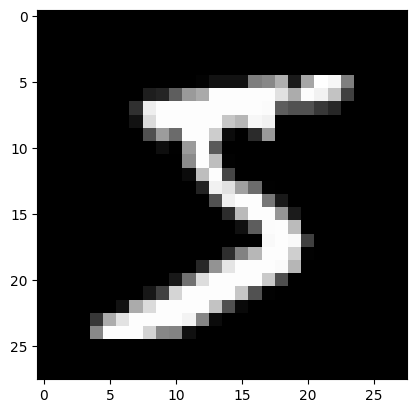

In [5]:
X = mnist.data
y = mnist.target
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))

### データの抽出

dataフォルダの下にimg_78フォルダを作成し、数字の7と8の画像だけ保存する
- 画像はそれぞれ200枚
- サイズは$28 \times 28$

In [6]:
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)
count7=0
count8=0
max_num=200  # 画像は200枚ずつ作成する

for i in range(len(X)):

    # 画像7の作成
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28×28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count7+=1

    # 画像8の作成
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 画像を28*28の形に変形
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 画像をPILに
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64に拡大
        pil_img_f.save(file_path)  # 保存
        count8+=1

<>:11: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-3758291778.py:11: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if (y[i] is "7") and (count7<max_num):
/tmp/ipython-input-3758291778.py:20: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if (y[i] is "8") and (count8<max_num):


## Self-Attentionモジュールの実装

入力$x$、Self-Attention Map$\sigma$について出力$r=x+\gamma\omicron$を生成する
- $\gamma$は係数で、初期値0として学習を開始する
- 学習可能な数値を与えるため、`nn.Parameter()`を利用する


In [7]:
class Self_Attention(nn.Module):
    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()
        # 1×1の畳み込み層を用いてpointwise convolutionを構築
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        # Attention Map作成時に正規化するためのソフトマックス
        self.softmax = nn.Softmax(dim=-2)
        # output = x +gamma*oであり最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        X = x  # 入力変数
        # Qの畳込みの後サイズ変形(B,C',W,H→B,C',N)
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        proj_query = proj_query.permute(0, 2, 1)  # 転置
        # Kの畳み込み後のサイズ変形、先ほどと同じ
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        # Q*Kを演算
        S = torch.bmm(proj_query, proj_key)  # バッチの全ての行列毎に演算
        # 規格化
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置してAttention Mapを得る
        # Self-Attention Mapを計算、まずサイズをB, C, Nへ
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))  # Attention Mapは転置して掛ける
        # Self-Attention MapであるoのテンソルサイズをXにそろえて出力
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o
        return out, attention_map

### Generatorの実装

- Spectral Normalizationが各層に追加されている
  - 最後の転置畳み込み層(last)には追加していない
- Self-Attentionモジュールが、layer3とlayer4の間、layer4とlastの間に設けられている
- どこに注目したかを可視化するため、Attention Mapを出力している

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
              kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
              kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
              kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        # Self-Attention層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
              kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        # Self-Attention層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size)
        self.last = nn.Sequential(  # 白黒画像なので出力チャネルは1
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
              stride=2, padding=1),
            nn.Tanh())
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)
        return out, attention_map1, attention_map2

#### Generatorの動作確認

学習前なので、ひとまずノイズのような画像がでればよい

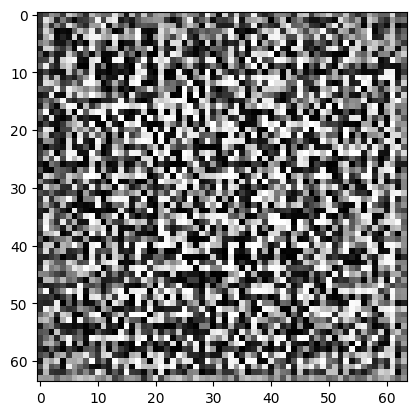

In [9]:
import matplotlib.pyplot as plt
G = Generator(z_dim=20, image_size=64)
# 入力する乱数
input_z = torch.randn(1, 20)
# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
# 偽画像を出力
fake_images, attention_map1, attention_map2 = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

### Discriminatorの実装

- こちらも各層にSpectral Normalizationが追加されている
  - 最後の層であるlastには追加していない
- Generator同様、layer3とlayer4の間、layer4とlastの間にSelf-Attentionが追加されている
- こちらも可視化のためにAttention Mapを出力している

In [10]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(  # 白黒画像なので入力チャネルは1
                nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)),
                nn.LeakyReLU(0.1, inplace=True))
        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # Self-Attention層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # Self-Attention層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)
        return out, attention_map1, attention_map2

#### Discriminatorの動作確認

特に現状で何か意味のある値が得られるわけではないが、d_outに真偽の確率が出力される

In [11]:
D = Discriminator(z_dim=20, image_size=64)  # 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)
d_out, attention_map1, attention_map2 = D(fake_images)  # 偽画像をDに入力
print(nn.Sigmoid()(d_out))  # 出力d_outにSigmoidをかけて0から1に変換

tensor([[[[0.4973]]]], grad_fn=<SigmoidBackward0>)


### DataLoaderの作成

In [12]:
def make_datapath_list():
    train_img_list = list()  # 画像ファイルパスを格納
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
    return train_img_list

#### 画像読み込み時に利用するTransromの作成

In [13]:
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    def __call__(self, img):
        return self.data_transform(img)

#### データローダのヘルパー関数

In [14]:
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    def __len__(self): # 画像の枚数を返す
        return len(self.file_list)
    def __getitem__(self, index): # 前処理した画像データを取得
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒
        img_transformed = self.transform(img)
        return img_transformed

#### DataLoaderの作成と動作確認

In [15]:
# ファイルリストを作成
train_img_list=make_datapath_list()
# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))
# DataLoaderを作成
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


## 学習用関数

Hingeロスを利用している
- BCEロスの利用も比較上できるようにしている

In [16]:
D_loss = []
G_loss = []
def train_model(G, D, dataloader, num_epochs):
    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    # 誤差関数を定義 → hinge version of the adversarial lossに変更
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64
    # ネットワークをGPUへ
    G.to(device)
    D.to(device)
    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    # epochのループ
    for epoch in range(num_epochs):
        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和
        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:
            # Discriminatorの学習
            imges = imges.to(device)
            # 正解ラベルと偽ラベルを作成(epoch最後のバッチは数が不足する可能性がある)
            mini_batch_size = imges.size()[0]
            d_out_real, _, _ = D(imges) # 真の画像を判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device) # 偽の画像を生成して判定
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            # LOSSの計算にhinge version of the adversarial lossを利用
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 誤差d_out_realが1以上で誤差0になる→d_out_real>1で1.0 - d_out_realが負の場合ReLUで0にする
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 誤差d_out_fakeが-1以下なら誤差0になる→d_out_fake<-1で1.0 + d_out_realが負の場合ReLUで0にする
            d_loss = d_loss_real + d_loss_fake
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            #  Generatorの学習(偽の画像を生成して判定)
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            # LOSSの計算にhinge version of the adversarial lossを利用
            g_loss = - d_out_fake.mean()
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            # ロスの管理
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        t_epoch_finish = time.time() # epochのlossと正解率
        D_loss.append(epoch_d_loss/batch_size)
        G_loss.append(epoch_g_loss/batch_size)
        if(epoch % 10 == 0):
          print('timer:  {:.4f} sec. : epoch {} / {} || D_Loss:{:.4f} / G_Loss:{:.4f}'.format(
            t_epoch_finish - t_epoch_start, epoch, num_epochs, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        t_epoch_start = time.time()
    # print("総イテレーション回数:", iteration)
    return G, D


### ネットワークの初期化

ネットワークの重みを初期化しておく

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (self_attntion1): Self_Attention(
    (query_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-2)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (self_attntion2): Self_Attention(
    (query_conv): Conv2d(512, 64, kernel_siz

## 学習・検証

5分ほど必要

In [18]:
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

timer:  4.9921 sec. : epoch 0 / 300 || D_Loss:0.1722 / G_Loss:0.0945
timer:  1.0967 sec. : epoch 10 / 300 || D_Loss:0.0009 / G_Loss:0.1476
timer:  1.0717 sec. : epoch 20 / 300 || D_Loss:0.1226 / G_Loss:0.1083
timer:  1.0767 sec. : epoch 30 / 300 || D_Loss:0.1224 / G_Loss:0.0634
timer:  1.0795 sec. : epoch 40 / 300 || D_Loss:0.1791 / G_Loss:0.0923
timer:  1.1049 sec. : epoch 50 / 300 || D_Loss:0.1932 / G_Loss:0.0639
timer:  1.0952 sec. : epoch 60 / 300 || D_Loss:0.2292 / G_Loss:0.0175
timer:  1.1025 sec. : epoch 70 / 300 || D_Loss:0.1796 / G_Loss:0.0249
timer:  1.1039 sec. : epoch 80 / 300 || D_Loss:0.1816 / G_Loss:0.0553
timer:  1.1264 sec. : epoch 90 / 300 || D_Loss:0.1827 / G_Loss:0.0494
timer:  1.1034 sec. : epoch 100 / 300 || D_Loss:0.2106 / G_Loss:-0.0382
timer:  1.1162 sec. : epoch 110 / 300 || D_Loss:0.1735 / G_Loss:0.0220
timer:  1.1197 sec. : epoch 120 / 300 || D_Loss:0.1839 / G_Loss:0.0295
timer:  1.1224 sec. : epoch 130 / 300 || D_Loss:0.1852 / G_Loss:0.0448
timer:  1.1654 s

ロス曲線の描画
- 最後にGのロスが上がり、Dのロスが下がることで、差がくっきりしていれば学習終了と考えてよい
- 場合によっては、エポック数が不足し、学習結果が芳しくない場合がある
- このテキストでは、このような初期化によるバラツキはあえて残しており、各人でその判別や問題解決を図ることを期待している

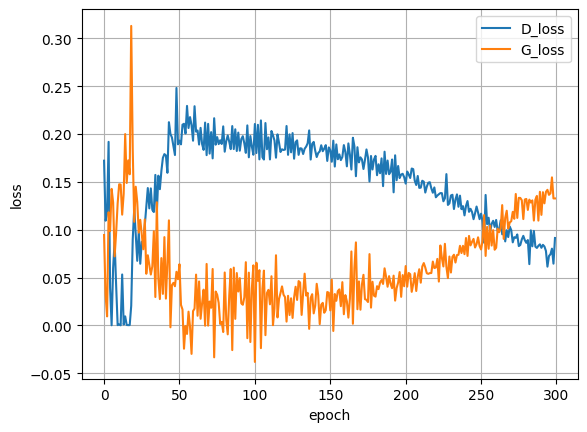

In [19]:
plt.clf()
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

### 生成画像と訓練データを可視化

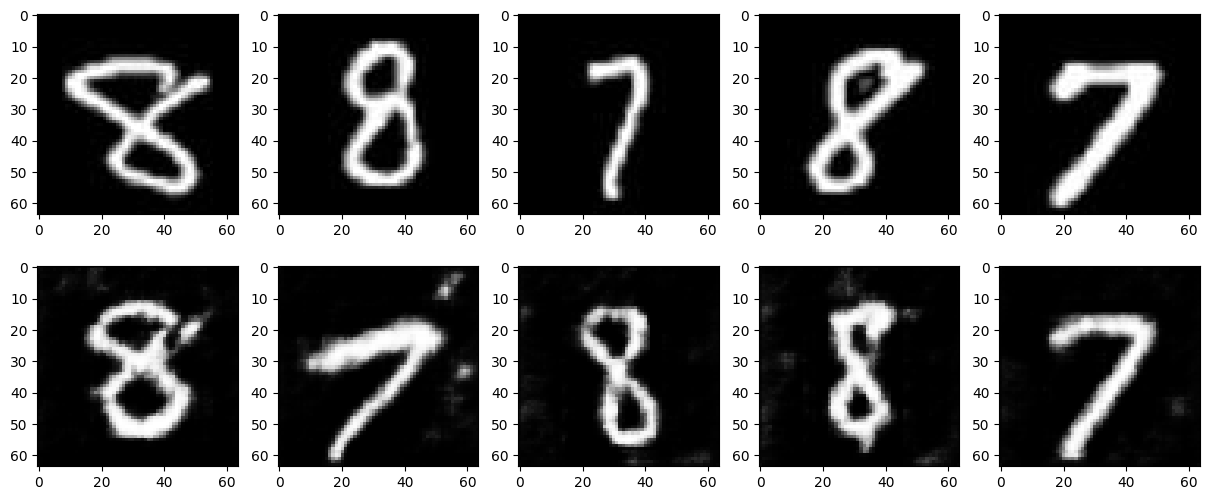

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
# 画像生成
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))
# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


### Attentiom Mapを出力

上段に生成データ、下段にAttention Mapの可視化
- 例として、画像の丁度中央にある座標(7,7)のピクセルを生成する際に、他のどの位置のピクセル量を特徴量にしたかを示している

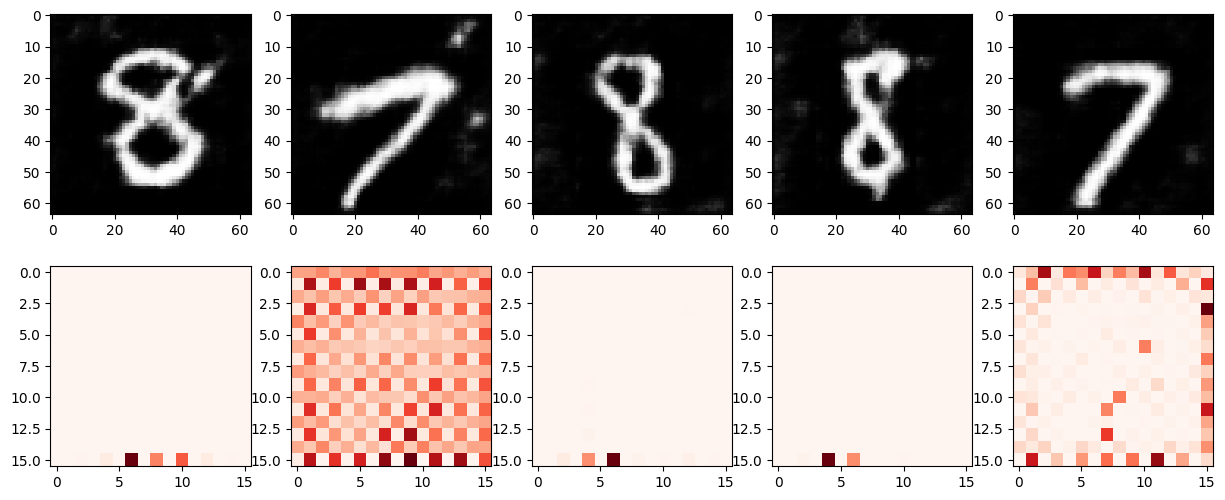

In [21]:
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に生成した画像データを
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    # 下段にAttention Mapの画像中央のピクセルのデータを
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

# 課題1 (SAGAN)

SAGANについて、MNISTの数字を変更して確認しなさい

# 課題2 (Attention)

Attentionとは何か、次の点に注意して簡潔にまとめなさい
- どのような目的で用いられるか？
- 計算速度に関してどのようなメリットが得られるのか？


# Seq2Seqによる自動翻訳


自動翻訳に挑戦してみよう

但し、短い時間で日本語翻訳を実現するため、あまり精度は期待しないこと

## Seq2Seqによる自動翻訳

単語を数値化する手法として、今回もnn.Embeddingを引き続き利用する

RNNについては既に説明済みであるため省略するが、次のイメージで翻訳作業が進む
  - なお、Encoder RNNは複数記述されているが、何度も説明するようにこれらは同一モデルであり、同一モデルを複数回利用することに注意する
  - 説明では展開された図(これをアンロールと呼ぶ)がよく利用される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seq_6.gif" width=1200>


## 自動翻訳

自動翻訳を考える。単純にネットワークの入力にある文章、ネットワークの出力に翻訳した文章を与え学習させればよいと考えるであろう。実際には、文章と翻訳した文章は長さが異なるため単純に処理できない
- 例えば、`I want to learn Artificial Intelligence.`を`私は人工知能を学びたい。`と翻訳するとする。
  - 学習の都合からすれば、Iを「私」、wantを「たい」といった対応をとって学習させたいであろうから、日本語は分かち書きが必要となる
- 分かち書きを行い、`I want to learn Artificial Intelligence.`を`私 は 人工知能 を 学び たい。`とする。これをそのまま食べさせてもよいが、次のような問題がある
  - そもそも、翻訳させたいのはこの文章だけではなく、様々な文章がある
  - 文章の長さや単語数も異なるため、入力ノード数は固定ではない
  - 翻訳された言語での文章の長さも変化するため、出力ノード数も異なる
- 記事分類では文章としての意味はなく、単語の並びとして扱えばよかったが、文章という単語の順番が問われる場合はどうするか？

## Seq2Seq

Seq2Seqは、シーケンスつまり並びを入力とし、並びを出力するために考案された手法である

まず、技術的なブレークスルーは次の通りである
- EncoderとDecoderにより構成され、AutoEncoderに似ているが中身は異なり、並びを重視するためRNNを利用する
- 並びに加えて始まりと終わりも重視するため、文章の開始を意味するStart of String(SOS)と文章の終わりを意味するEnd of string(EOS)をスペシャルキャラクタとして導入し、SOS 文章 EOSとして表現する
  - つまり入力と出力で長さが変化してもよい

Seq2Seqを用いて翻訳するイメージは次の通り
- contextが潜在空間表現となる
- つまり、文章そのものが潜在表現として現れるので、英語の文章をencoderで潜在表現とし、これを日本語のdecoderで元に戻せば翻訳できる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seq_4.gif" width=800>

### Attention

察しの良い人は気づいているかもしれないが、ばらばらの単語で構成される文章がcontextとして簡単に潜在空間で表現できるのだろうか？という疑問はまっとうな疑問といえる
- 実際、contextを用いるだけでは、長文の扱いが難しくなり、これがモデル設計上の障害となる

その解決策としてAttentionが提案され、機械翻訳精度が向上した
- Attentionとは、入力系列の中から必要な要素に注目する手法のこと

Attentionは、「ここに注意しろ！」と重要事項をマークする機構であり、例では「étudiant」(仏語で「学生」)に注目させることで精度向上を狙う

#### Attentionの特徴その1

Attentionではあるcontextを注目させるために、Encoderはcontextとしてまとめた状態(最後の潜在空間ベクトル)だけでなく、各単語処理における全context(全潜在空間ベクトル)を渡す

<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seq_7.gif" width=1000>


#### Attentionの特徴その2

注目できるようにするために、出力を生成する前に次のような処理を施す
- Encoderの全潜在空間ベクトルを見る
  - 各潜在空間ベクトルは各入力系列の要素(ここでは単語)に強く影響を受けた値となる
- 各潜在空間ベクトルにスコアとしての重みを与える
  - 実際の計算方法は後述
- 各潜在空間ベクトルにSoftMaxを通した重みを乗算する
  - 重みの大きなベクトルは増幅され、小さなベクトルは縮小される
  - この処理をDecoder各ステップで行う

ここまでの処理をアニメ化してみると次のようになる
- $h_1$, $h_2$, $h_3$の全ベクトルを受け取る
- 最初は潜在空間ベクトルの初期入力値$h_{init}$とENDトークンを用いて潜在空間ベクトルh4を入手する
  - この時出力は破棄する(出力は使わない!)
- 受け取った全潜在空間ベクトルと$h_4$に対して重みを算出、SoftMaxを施した値を掛けてcontext$C_4$を作成
- $h_4$と$C_4$を結合して全結合層に入れ、その結果を新たな次のステップへの入力(ここではENDであった)とする

この処理を繰り返す
  - 実際にはさらにteacher forcingというテクニックを利用する(後述)

<img src="http://class.west.sd.keio.ac.jp/dataai/text/attention_tensor_dance.gif" width=1200>



結果的に、次のようにたとえ長さが異なったとしても、それぞれ、どの潜在空間h(フランス語の単語のようなもの)にどの程度注目して翻訳される単語(英語)を導き出すべきかを適切に判断できるようになる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seq_9.gif" width=600>

Attentionを用いることで各単語毎の対応が訓練時に学習できるようになる

仏語から英語に変換する場合、次のような対応となり、かつ言語における語順の差も吸収されていることがわかる
- 仏語はzone économique européenneと、形容詞が牛鹿に来るため英語と語順が逆になっているがそれも含めて正しく表現できている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/attention_sentence-1.png" width=400>

### 準備処理とEncoder

PyTorchのチュートリアルに優れた例があるためこれを利用する
- 例は上記のSeq2Seqの説明をそのまま実装している
- チュートリアルは仏語と英語の翻訳であったが、これではつまらないし、仏語はわからないため、日本語にチャレンジする
  - ただし、ちょっとだけチートする
  - 日本語を実現しているコードは見当たらないので丁度良い
  - 時間がある人、チャレンジしたい人はMeCabやT5Tokenizerを利用するとよい
- 実際のモデルとして、シーケンスつまり順番を問題とするためRNNを用いる。ここでは、比較的処理速度が速いGRUを利用する

まずはデータをダウンロードする
- fr.txt: 普通によくある仏語と英語を翻訳するためのテキスト
  - コメントを外して利用すること
- jp.txt: 本格的に日本語にチャレンジしたい人向け、MeCabの力を借りる必要があるので、発展問題的に利用
  - コメントを外して利用すること
- jp-k.txt: 今回実際に利用する「ハック済」テキストで、要するに先にカタカナ変換してある
  - MeCabを使った方が正確であるが、お手軽に済ませるためkakasiを利用した

In [22]:
import os
#if not os.path.exists('fr.txt'):
#  !wget "https://drive.google.com/uc?export=download&id=15VFFwii1jbFXsfWmrd_9MErrOLitF_WD" -O fr.txt
#if not os.path.exists('jp.txt'):
#  !wget "https://drive.google.com/uc?export=download&id=1boWJ1CkOxoxN2qIlJjt9KZ-g2I_HuxM5" -O jp.txt
if not os.path.exists('jp-k.txt'):
  !wget "https://drive.google.com/uc?export=download&id=1-MNyU0oG-EiGqYa5whvcoJIitDuS4GCi" -O jp-k.txt

--2026-01-14 10:48:27--  https://drive.google.com/uc?export=download&id=1-MNyU0oG-EiGqYa5whvcoJIitDuS4GCi
Resolving drive.google.com (drive.google.com)... 74.125.137.113, 74.125.137.138, 74.125.137.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1-MNyU0oG-EiGqYa5whvcoJIitDuS4GCi&export=download [following]
--2026-01-14 10:48:27--  https://drive.usercontent.google.com/download?id=1-MNyU0oG-EiGqYa5whvcoJIitDuS4GCi&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5683255 (5.4M) [application/octet-stream]
Saving to: ‘jp-k.txt’

jp-k.txt            100%[===================>]   5.42M  28.3MB/s    in

各種ライブラリを読み込む

In [23]:
cuda = "cuda:0"
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device(cuda if torch.cuda.is_available() else "cpu")

#### データの読み込み

- ファイルからデータを読み込む
  - データとして、タブで隔てられ、スペースで単語毎に区切られたデータを利用する
  - I have a cold.[TAB]J'ai froid.
  - I have a cold.[TAB]Kaze wo Hiita.

- 新しい単語を見つけるたびに新しい番号を与え、これをword2indexとしてwordからindexへの変換関数(実際は連想配列)とする
  - これは記事分類の例と同じ
  - ifでword2indexに加えたいwordがなかった場合のみ追加処理を行う
  - pythonの辞書型を利用し、word2indexにwordを加える  
  - word2countを1にする、つまりその文字は存在するということ
  - 新しい単語が見つかるごとにn_wordは+1され、index2wordのn_word番目の単語をwordにする
- その逆引きを行うindex2wordも作成する
- さらにレアな単語は学習の邪魔になるため置き換えを行うが、そのために必要な単語の出現数を管理するword2countも作成する

以上を管理するヘルパークラスLangを設計する

In [24]:
SOS_token = 0
EOS_token = 1
class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2  # Count SOS and EOS
  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)
  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

単純化するためにUnicode文字(例えば仏語のアクセントなど)をアスキー文字(普通のアルファベット)に変え、総て小文字とし、さらに各種記号を単語と同様に一つの記号にする
- この機構をすり抜けるためにjp-k.txtではハックを行っている




In [25]:
def unicodeToAscii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
  )

def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

データファイルから行ごと読み込み、さらに行をペアに分割する
- 入力テキストのjp-k.txtの行は全て英語[TAB]他の言語(ここでは日本語のローマ字表記)、となっており、この2つのセットをペア(pairsもしくはpair[0]とpair[1])と呼ぶ
- 他の言語から英語へ翻訳する場合は、reverseフラグを用いることでペアを逆にすることができる


In [26]:
def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")
  # ファイルを読んで行に分割
  lines = open('jp-k.txt', encoding='utf-8').read().strip().split('\n')
  # 各行をタブで分割
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
  # reverseフラグが立っていたら反転する
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
  return input_lang, output_lang, pairs

長い文章が含まれるため、短く単純な文章に短縮してデータセットを構築する
- ここでは最大長を 10 単語とする
  - モデルの大きさを制限したいため
- 英語文章の特徴である省略形を画一化しておく
  - 実際には日本語についても同様の処理が必要であるが、今回は対応していない

In [27]:
MAX_LENGTH = 20
eng_prefixes = (
  "i am ", "i m ",
  "he is", "he s ",
  "she is", "she s ",
  "you are", "you re ",
  "we are", "we re ",
  "they are", "they re "
)
def filterPair(p):
  if(len(p[0].split(' ')) < MAX_LENGTH and # 入力文章が10文字未満
    len(p[1].split(' ')) < MAX_LENGTH and # 出力文章が10文字未満
    p[1].startswith(eng_prefixes)): # 上記の一般的な始まり方をしているかどうか
    return True
  else:
    return False
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)] # pairs[0]とpairs[1]について制限に該当するか確認

#### 経過時間計算ルーチン

今回かなり時間が必要になるので、現在時刻と進捗%が与えられたときに経過時間と残りの見積もり時間をプリントするヘルパー関数を定義する
- 経過時間と予定終了時間を求める小さいが強力なルーチン
- 引数として全エポック数と現在実行のエポック数などを与えると経過時間と終了予定時間を表示する

なお、普通は、hydraでパラメータをコマンドラインで設定、wandbで記録管理というのが現状では最強のデータ管理手法と思われる
- Google Colabだとちょっと気を付けないといけないかもしれない
- https://wandb.ai/


In [28]:
import time
import math
def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)
def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#### データセットの作成
- まず、テキストファイルを読んで行に分割し、これをペアに分割する(readLangs)
- テキストの文字をアスキーに変換し長さを限定する(filterPairs)
- ペアの文章から単語リストを作成する(addSentencesメソッド)

In [29]:
def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) # データの読み込み
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs) # 制限を満たすpairsのみ利用
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs: # input_langとoutput_langに文章を追加
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:") # input_langとoutput_langに言語名と単語数を追加
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs
input_lang, output_lang, pairs = prepareData('eng', 'ja', True)

Reading lines...
Read 77816 sentence pairs
Trimmed to 5658 sentence pairs
Counting words...
Counted words:
ja 5139
eng 2440


上記のように、8万近くある文章から5658個の文章だけ選別
- 日本語は5139語、英語は2440語

pairsには全ての文章が入っているため、ここから乱択して表示させてみる
- random.choice(seq)は、空でないseqからランダムに要素を返す


In [30]:
print(random.choice(pairs))

['mada shokku dayo .', 'i m still in a state of shock .']


##  モデル構築に必要な構造図

Encoder、Decoder、学習などの処理プロセスを理解するには、次の図を参照するとよい
- より実装形態に近い図となっている
- 青い部分がEncoder、赤い部分がDecoderである

<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seqencdecfig.png" width=800>

#### リカレントニューラルネットワークを利用する

ここでは`output, hidden = self.gru(output, hidden)`とあるようにGRUを利用
- EncoderとDecoder両方で利用することから、性能のわりにコストが小さいのが良いためRNNとしてGRUを利用する

### Encoder

- 特に工夫なく、まずEmbeddingを行い、GRUにかける
- 潜在空間ベクトルの初期値を0にするためのinitHiddenメソッドも準備
- ここではGRU(図ではRNN)の一つ分のモデル構造である
  - 同一モデルに順に文字を入力するが、その部分はEncoder関数に記述されている

In [31]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
  def forward(self, etextvec, hidden):
    embv = self.embedding(etextvec).view(1, 1, -1)
    enc2dec, hidden = self.gru(embv, hidden)
    return enc2dec, hidden
  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

### Attentionを用いたDecoder

Encoderの出力ベクトルを用いて翻訳を作成する
- 実際には単語のシーケンスを出力する

次のパスが核心部分である

#### 1. 重みの計算

最初に attention重みのセットを計算する
- `embedded = self.embedding(input)`としてまずはEmbeddingする
  - 繰り返しになるがword2vecを使った方がよくなる可能性がある
- `embedded = self.dropout(embedded)`として10%Dropoutする
  - 文章表現の多様性を受け入れるため過学習を避ける
- `attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)`として重みを計算する
  - `[0]`は、`[[1, 2, 3]]`を`[1, 2, 3]`とするだけで内容は変わらない
  - `torch.cat`でテンソルをくっつける
    - `torch.cat`は興味深い動作をするので確認するとよい
    - dimは、`torch.size`で示されるテンソルの型について何番目の要素を連結するか(つまりその他の要素は完全に一致していなければならない)を指定する
```
i1 = torch.randn(1, 2, 3)
i2 = torch.randn(2, 2, 3)
i3 = torch.randn(3, 2, 3)
ilist = [i1, i2, i3]
o1 = torch.cat(ilist, dim=0) # OK! 0行目だけが違う
o2 = torch.cat(ilist, dim=1) # NG!
```

#### 2. 重みを掛け合わせる

torch.bmmを用いて、attn_weightsとencoder_outputsの行列積を計算する

- 単純に行列の積を計算するが、実際にはバッチになっており複数の行列積を同時に行う必要がある
- `torch.bmm`は過去に1度登場しているが、バッチで行列積を計算する
  - テンソルごとを掛け算するため、unsqueeze(0)している
    - 例えば、`[1, 2]`が、`[[1, 2]]`となるイメージ
  - (0)はdimつまりどの次元で新しいテンソルを挿入するかを表す
    - dim=1とすると、先の例では`[[1],[2]]`となる
  - その他のPyTorchにおける行列積の計算について、巻末にまとめておく


#### 3. 重みを結合する

torch.catを用いて、embeddedとattn_appliedを結合する
- 先ほどと同様に`[0]`としており、`dim=1`である

#### 4. 全結合層で次元削減する

結合したので要素数が増えており、これをhidden_sizeつまり潜在空間ベクトルのサイズまで縮約する
- 全結合層なので活性化関数(Activation Function)を指定、ここではReLUを用いるため、`output = F.relu(output)`とする

#### 5. SoftMaxを計算する

`output = F.log_softmax(self.out(output[0]), dim=1)`としてsoftmaxを計算する
- logをとるのはあまり値が発散しないようにするため


<img src="http://class.west.sd.keio.ac.jp/dataai/text/seq2seqencdec2.png" width=800>

In [32]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length
    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)
  def forward(self, textvec, hidden, enc2dec): # hiddenは最初はエンコーダのhiddenで次からは自身のhidden
    embvec = self.embedding(textvec).view(1, 1, -1) # (1)翻訳語教師文章のエンコーディング(hidden_sizeのベクトルへ埋め込み)
    embvec = self.dropout(embvec) # 一部の計算をスキップ
    attn_weights = F.softmax(
      self.attn(torch.cat((embvec[0], hidden[0]), 1)), dim=1)
    # (2) 埋め込まれた入力語とRNN(GRU)の隠れベクトルhiddenを結合、サイズがhidden_size*2になる
    #     これをhidden_sizeへFCで変換、softmaxで確率に変換してattention weightsを得る
    context_vector = torch.bmm(attn_weights.unsqueeze(0),
      enc2dec.unsqueeze(0)) # (3) atten_weightsとencoderの出力を掛け算してcontext vectorを計算
    output = torch.cat((embvec[0], context_vector[0]), 1) # (4) embvecとcontext_vectorを連結し、サイズを変換してGRUへ入力
    output = self.attn_combine(output).unsqueeze(0) # (5) hidden_size*2のサイズからhidden_sizeへFCで変換
    output = F.relu(output) # (6) GRUに入れる前に活性化関数を施す
    output, hidden = self.gru(output, hidden) # (6) GRUを利用
    output = F.log_softmax(self.out(output[0]), dim=1) # (7) 最後にsoftmaxを掛けることで文字が確定
    return output, hidden, attn_weights
  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

### 学習用関数



In [33]:
teacher_forcing_ratio = 0.5
def train(etextvec, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
  # 初期化
  enc_h = encoder.initHidden() # 中身はtorch.zeros
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  input_length = etextvec.size(0)
  target_length = target_tensor.size(0)
  enc2dec = torch.zeros(max_length, encoder.hidden_size, device=device) # エンコーダの出力群を初期化
  loss = 0

  for ei in range(input_length): # seq2seqでは並列化できず入力文章の単語ID列を順番に処理する
    enc_o, enc_h = encoder(etextvec[ei], enc_h) # Encoder(青)のRNNの部分で中でEmbeddingされている
    # EncoderのTextVecの部分で、ここは入力文章コードをと隠れベクトルを順に代入、全ての単語で同じencoderを利用
    enc2dec[ei] = enc_o[0, 0] # 結果としての出力をエンコーダ出力群に代入

  dtextvec = torch.tensor([[SOS_token]], device=device) # decoderの初期入力は文章開始記号、<s>を入れている部分
  dec_h = enc_h # encoderの隠れベクトルをdecoderの初期隠れベクトルにする(ench2dech)
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  if use_teacher_forcing: # Teacher forcing: ターゲットを次の入力に入れる
    for di in range(target_length):
      dec_o, dec_h, dec_attn = decoder(dtextvec, dec_h, enc2dec)
      loss += criterion(dec_o, target_tensor[di])
      dtextvec = target_tensor[di]  # Teacher forcingなので答えを入れる
  else: # teacher forcingなし: 自身の予測値を次の入力に入れる
    for di in range(target_length):
      dec_o, dec_h, dec_attn = decoder(dtextvec, dec_h, enc2dec)
      topv, topi = dec_o.topk(1) # topkによりdec_oから最大のk(ここでは1)個の要素の値と場所を返す
      dtextvec = topi.squeeze().detach()  # detach from history as input
      loss += criterion(dec_o, target_tensor[di])
      if dtextvec.item() == EOS_token: # 文章の終わりを検出したのでここで終了
        break
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()
  return loss.item() / target_length

目新しい命令`torch.topk`が含まれている
- テンソルの与えられた次元(dim)にある値全ての中から大きい順にk個の値を返す
- topk(1)は、単純に最も大きい値を返すことになる
- torch.max()でも代用できるが、大値とその位置を示すインデックス（=argmax）がタプルで戻るため、[0]などをつける必要がある

### Teacher forcing

このままでは学習速度が遅いため、これを「チートして」速くする

図はLSTMだが、GRUを利用しているので注意すること

<img src="http://class.west.sd.keio.ac.jp/dataai/text/teacherforcing1.png" width=600>

上記の図の通り、Encoder前の出力をそのまま次の入力として使って学習する構造である
- この方法は連鎖的に誤差が大きくなり、学習が不安定になる、収束が遅いなどの問題が発生する

そこで、次の入力としてDecoderの推測結果を利用する代わりに、実際のターゲット出力、つまり教師データをそのまま次の入力として利用する

<img src="http://class.west.sd.keio.ac.jp/dataai/text/teacherforcing2.png" width=600>

この手法をteacher forcingと呼ぶ
- 速く収束させることができる一方で、訓練されたネットワークが入力に引っ張られ過ぎ、学習過程や結果が不安定になる可能性がある
- また、teacher-forced ネットワークの出力を観察するとわかるが、汎化性能が乏しくなる
  - 例えば、最初の 2, 3 単語から意味を類推することはできるが、結局翻訳センテンスを作成するという目的からは離れており、翻訳という観点で適切に学習できない

そこで、Scheduled Samplingを用いる
- Schedule Samplingは次の図のように、ターゲット$y_t$を入力とするか、生成された$w_t$を入力とするか確率的にサンプルする手法

<img src="http://class.west.sd.keio.ac.jp/dataai/text/scheduled-sampling.png" width=600>

- PyTorch autogradは設計自由度が高く、単純な if ステートメントで "teacher forcing" を使用するか否かをランダムに選択することができる
  - teacher_forcing_ratioで利用割合を調整でき、現状50%としている

## 訓練(Training)

### 訓練データの準備

訓練用に、各ペアについて入力tensor(入力センテンスの単語のインデックス)とターゲットtensor(ターゲット・センテンスの単語のインデックス)を作成する
- 両方のシーケンスに EOS トークンを追加しておく

In [34]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]
def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

#### 訓練プロセス

- タイマーを開始
- 各種初期化を行う
- イテレータを設定
  - optimizer と criterion を初期化
  - 訓練ペアのセットを作成
  - を準備
  - 一定間隔で進捗 (サンプルの %, ここまでの時間, 見積もり時間) と平均損失を表示する



## 学習(Training)

まず初期化する

In [35]:
hidden_size = 300 # 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
n_iters = 100000
print_every = 2000
plot_every=5000
learning_rate=0.01
start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
criterion = nn.NLLLoss()

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

学習を行う
- この部分を再度実行すると追加学習が可能である
- 実行には45分程度必要となるので注意すること
- seq2seqの欠点だが並列化できない
  - さすがに厄介なので、予想終了時刻を表示するように工夫している

In [37]:
for iter in range(1, n_iters + 1):
  training_pair = training_pairs[iter - 1]
  input_tensor = training_pair[0] # 翻訳前文章の単語コード列
  target_tensor = training_pair[1] # 翻訳後文章の単語コード列
  loss = train(input_tensor, target_tensor, encoder,
    decoder, encoder_optimizer, decoder_optimizer, criterion)
  print_loss_total += loss
  plot_loss_total += loss
  if iter % print_every == 0:
    print_loss_avg = print_loss_total / print_every
    print_loss_total = 0
    print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
      iter, iter / n_iters * 100, print_loss_avg))
  if iter % plot_every == 0:
    plot_loss_avg = plot_loss_total / plot_every
    plot_losses.append(plot_loss_avg)
    plot_loss_total = 0

0m 52s (- 42m 47s) (2000 2%) 3.4617
1m 37s (- 39m 4s) (4000 4%) 3.1159
2m 24s (- 37m 39s) (6000 6%) 3.0032
3m 10s (- 36m 29s) (8000 8%) 2.8772
3m 57s (- 35m 33s) (10000 10%) 2.7610
4m 43s (- 34m 39s) (12000 12%) 2.5456
5m 29s (- 33m 46s) (14000 14%) 2.4313
6m 16s (- 32m 57s) (16000 16%) 2.3151
7m 4s (- 32m 11s) (18000 18%) 2.1988
7m 50s (- 31m 23s) (20000 20%) 2.0679
8m 37s (- 30m 36s) (22000 22%) 1.9461
9m 25s (- 29m 49s) (24000 24%) 1.8496
10m 12s (- 29m 3s) (26000 26%) 1.7412
10m 59s (- 28m 16s) (28000 28%) 1.6044
11m 47s (- 27m 30s) (30000 30%) 1.5564
12m 35s (- 26m 44s) (32000 32%) 1.4562
13m 22s (- 25m 58s) (34000 34%) 1.4187
14m 10s (- 25m 11s) (36000 36%) 1.3365
14m 57s (- 24m 24s) (38000 38%) 1.2539
15m 45s (- 23m 38s) (40000 40%) 1.1576
16m 33s (- 22m 51s) (42000 42%) 1.1368
17m 20s (- 22m 4s) (44000 44%) 1.0192
18m 8s (- 21m 17s) (46000 46%) 0.9840
18m 56s (- 20m 31s) (48000 48%) 0.9548
19m 44s (- 19m 44s) (50000 50%) 0.8767
20m 31s (- 18m 57s) (52000 52%) 0.8512
21m 19s (- 

#### 結果のプロット

訓練の間に保存した損失値の配列 plot_losses を使用する

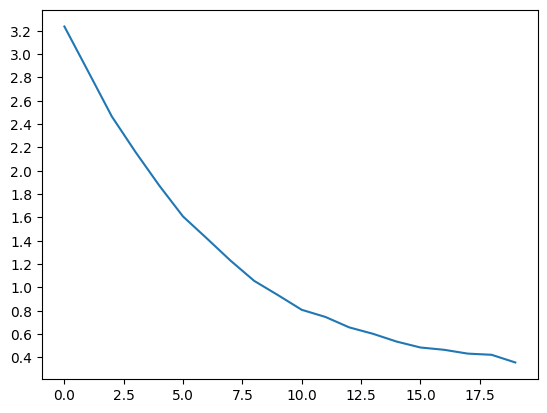

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

## 評価(Evaluation)

評価は殆ど訓練と同じ手順を踏む

ターゲットとなる文章がないため、各ステップのデコーダの予測結果を自身に戻して予測する
- 単語を予測するたびに、その出力文字列を追加し、EOFトークンが予測された時点で終了する
- Decoderのattention出力について、後ほど注目度合いを見るために保存しておく

In [39]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0] # Encoderの出力をすべて蓄える
    decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
    decoder_hidden = encoder_hidden
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token: # EOFが予測されたので終了
        decoded_words.append('<EOS>')
        break
      else:
        decoded_words.append(output_lang.index2word[topi.item()]) # 得られた文字IDから文字に変換して加える
      decoder_input = topi.squeeze().detach() # デコーダの出力を次の入力へ
  return decoded_words, decoder_attentions[:di + 1]

訓練セットからランダムな文章を選び出し、これを翻訳させる
- 実際にデータセットにある文章であるため、フェアではない

In [40]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

In [41]:
evaluateRandomly(encoder, decoder)

> sakuya hagomen .
= i m sorry about last night .
< i m sorry about last night . <EOS>

> daijoubu dayo . saikin isogashi idakedayo .
= i m ok . i ve just been busy recently .
< i m ok . i ve just been busy recently . <EOS>

> ore tachi wo tasuke rarerunohaomaedakenandayo .
= you re the only one that can help us .
< you re the only one that can help us . <EOS>

> taijuu ga ochi tekiteruno .
= i m losing weight .
< i m losing weight . <EOS>

> watashi ha chichi no kawari wotsutometeirunodesu .
= i am acting for my father .
< i am acting for my father . <EOS>

> kun ga tomu wo kiniitte kurete bokuha totemo ureshi i .
= i m so happy you like tom .
< i m so happy you like tom . <EOS>

> kareha inu ga kowai .
= he is afraid of dogs .
< he is afraid of dogs . <EOS>

> o mae haitsumo ooge sanandayo .
= you re always exaggerating .
< you re always exaggerating . <EOS>

> kanojo hamada oya nosune wokajitteiru .
= she s still dependent on her parents .
< she s still dependent on her parents . <E

では、好きな文章を翻訳させてみよう
- ただし、学習に用いた単語以外を利用するとEmbeddingで未知の番号となるため失敗する

In [42]:
kanatext = "kareha sono hoteru ni nichimae kara toma tteimasu ."
' '.join(evaluate(encoder, decoder, kanatext)[0])

'he s been staying at that hotel at five days . <EOS>'

短時間で学習しており、利用しているデータの品質も良くないため、お遊び程度で試してみるとよい

## Attentionの可視化

attentionの良い点の一つとして、理解しやすい注目度合いの出力を得ることができる点にある
- 入力シーケンスの特定のEncoder出力における重みであるため、各ステップでどこに注目するのかを見ることができる
- 列を入力ステップ、行を出力ステップとする行列としてattentionを見るには、単に`plt.matshow(attentions)`とすればよい


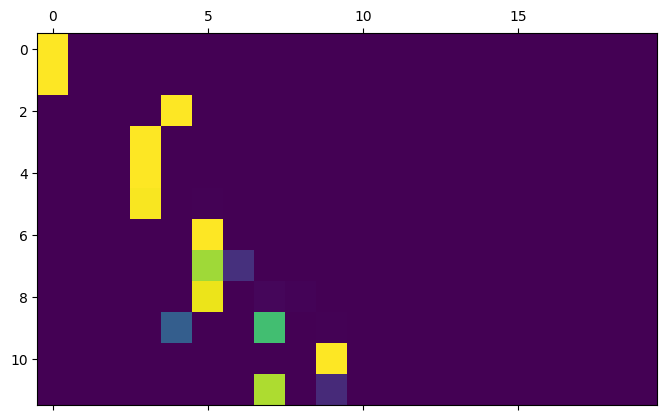

In [43]:
output_words, attentions = evaluate(encoder, decoder, "kareha sono hoteru ni nichimae kara toma tteimasu .")
plt.matshow(attentions.numpy())

より分かりやすく表示するため、軸とラベルなどを設定する

In [44]:
def showAttention(input_sentence, output_words, attentions):
  # Set up figure with colorbar
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.numpy(), cmap='bone')
  fig.colorbar(cax)
  # Set up axes
  ax.set_xticklabels([''] + input_sentence.split(' ') +
                     ['<EOS>'], rotation=90)
  ax.set_yticklabels([''] + output_words)
  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(encoder, decoder, input_sentence)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  showAttention(input_sentence, output_words, attentions)

input = kareha sono hoteru ni nichimae kara toma tteimasu .
output = he s been staying at that hotel at five days ago . <EOS>


/tmp/ipython-input-2170115078.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-2170115078.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


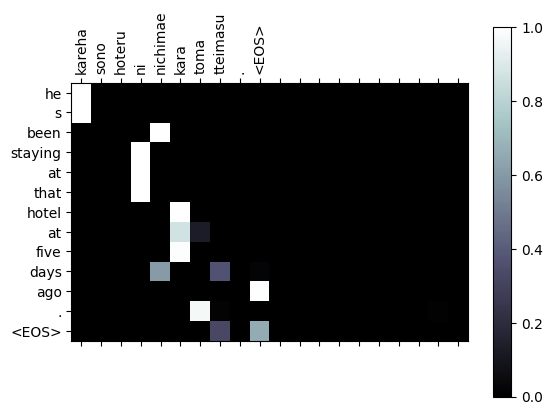

In [45]:
evaluateAndShowAttention("kareha sono hoteru ni nichimae kara toma tteimasu .")

# 課題3

より多くの層、より多くの隠れユニットとし、処理時間と結果を比較しなさい

# 課題4

次に示すような、シンプルなDecoderを用いて比較評価しなさい
- 下記に限らず、Decoderを工夫するとよい
```
# シンプルなDecoderの例
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

# 課題5

異なるデータセットを試しなさい

- 翻訳する先を英語にしたいので翻訳対象を英語とするのは意味がない
- できれば、その言葉が理解できて、翻訳結果についても正しくネイティブとして議論できることが望ましいが、普通にGoogle翻訳でも問題なく対応できるであろう
  - 探せば、様々な言語のデータセットがあることがわかります
  - ドイツ語などがおすすめです

# 課題6

日本語の字句解析に記事分類で利用したMeCabを使いなさい
- 精度向上が期待できる

# 課題7

word2vecやGloVeなどの事前訓練された単語埋め込みで置き換えなさい